# **Flight Price Prediction Using Supervised ML**

**Dataset Used: [*Dataset*](https://drive.google.com/drive/folders/1lPoRgB7CmvT6lPs--0YTVy2tPLTANmly?usp=sharing)**

# **Importing Required Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score

# **Importing Train Data**

In [2]:
train_data = pd.read_csv("Data_Train.csv")

In [3]:
train_data = train_data.drop("Unnamed: 0", axis = 1)

In [4]:
train_data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [5]:
pd.set_option('display.max_columns', None)

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


CLEARLY, NO NULL DATA IS THERE!

LETS CONFIRM THIS BELOW

In [7]:
train_data.isnull().sum()


Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [8]:
train_data["Duration"].value_counts()

2h 50m     550
1h 30m     386
2h 55m     337
2h 45m     337
2h 35m     329
          ... 
30h 25m      1
42h 5m       1
37h 10m      1
29h 10m      1
36h 25m      1
Name: Duration, Length: 368, dtype: int64

# **EXPLORATORY DATA ANALYSIS**

We can see that ***Date_of_Journey*** is a object data type and in order to use this in our model for prediction we need to convert it into ***timestamp***!

We can do this easily with the help of ***pandas.to_datetime*** method.

We will add two columns here:
1. Journey_day -> Day of Journey
2. Journey_month -> Month of Journey

In [9]:
train_data["Journey_day"] = pd.to_datetime(train_data.Date_of_Journey, format="%d/%m/%Y").dt.day

In [10]:
train_data["Journey_month"] = pd.to_datetime(train_data["Date_of_Journey"], format = "%d/%m/%Y").dt.month

In [11]:
train_data["Journey_Year"] = pd.to_datetime(train_data["Date_of_Journey"], format = "%d/%m/%Y").dt.year

In [12]:
# Checking if there are multiple Journey years.
train_data["Journey_Year"].value_counts()

2019    10683
Name: Journey_Year, dtype: int64

In [13]:
# Since its only one year, i.e. 2019, we can drop this column and also we can now drop the parent column, i.e. **Date_of_Journey**.
train_data.drop(['Date_of_Journey','Journey_Year' ], axis = 1, inplace = True)

Now, we need to perform the same steps for **Dep_Time**, **Arrival_Time** to extract values we need for our model.

In [14]:
#For Dep_time column.
# Extracting Hours.
train_data["Dep_hour"] = pd.to_datetime(train_data["Dep_Time"]).dt.hour

# Extracting Minutes.
train_data["Dep_min"] = pd.to_datetime(train_data["Dep_Time"]).dt.minute

# Now we can drop Dep_Time as it is of no use to our model.
train_data.drop(["Dep_Time"], axis = 1, inplace = True)

In [15]:
#For Arrival time column.
# Extracting Hours
train_data["Arrival_hour"] = pd.to_datetime(train_data.Arrival_Time).dt.hour

# Extracting Minutes
train_data["Arrival_min"] = pd.to_datetime(train_data.Arrival_Time).dt.minute

# Now we can drop Arrival_Time as it is of no use to our model
train_data.drop(["Arrival_Time"], axis = 1, inplace = True)

For the **Duration_time** column,  we can create two lists, *Hours* and *Minutes* and then add them to our dataframe!

In [16]:
duration = list(train_data["Duration"])

for i in range(len(duration)):
    if len(duration[i].split()) != 2:    # Check if duration contains only hour or mins
        if "h" in duration[i]:
            duration[i] = duration[i].strip() + " 0m"   # Adds 0 minute
        else:
            duration[i] = "0h " + duration[i]           # Adds 0 hour

duration_hours = []
duration_mins = []
for i in range(len(duration)):
    duration_hours.append(int(duration[i].split(sep = "h")[0]))    # Extract hours from duration
    duration_mins.append(int(duration[i].split(sep = "m")[0].split()[-1]))

In [17]:
# Adding duration_hours and duration_mins list to train_data dataframe

train_data["Duration_hours"] = duration_hours
train_data["Duration_mins"] = duration_mins

In [18]:
# Now we can remove the Duration column.
train_data.drop(["Duration"], axis = 1, inplace = True)

# **Handling Categorical Data**
Now that we have handled the time and data data, we can shift our focus to preprocessing the categorical data in our dataframe in order to make it fit for training our model

We can do this easily with the help of ***OneHotEncoder*** and ***LabelEncoder***

We will perform our operations on various columns by creating new dataframes and in the end we will concatenate all the dataframes!

In [19]:
train_data["Airline"].value_counts()

Jet Airways                          3849
IndiGo                               2053
Air India                            1752
Multiple carriers                    1196
SpiceJet                              818
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: Airline, dtype: int64

In [20]:
Airline = train_data[["Airline"]]
Airline = pd.get_dummies(Airline, drop_first= True)
Airline.head()

,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy
0,0,0,1,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0


In [21]:
train_data["Source"].value_counts()

Delhi       4537
Kolkata     2871
Banglore    2197
Mumbai       697
Chennai      381
Name: Source, dtype: int64

In [22]:
Source = train_data[["Source"]]
Source = pd.get_dummies(Source, drop_first= True)
Source.head()

,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai
0,0,0,0,0
1,0,0,1,0
2,0,1,0,0
3,0,0,1,0
4,0,0,0,0


In [23]:
train_data["Destination"].value_counts()

Cochin       4537
Banglore     2871
Delhi        1265
New Delhi     932
Hyderabad     697
Kolkata       381
Name: Destination, dtype: int64

In [24]:
Destination = train_data[["Destination"]]
Destination = pd.get_dummies(Destination, drop_first = True)
Destination.head()

,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,0,0,0,0,1
1,0,0,0,0,0
2,1,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,1


In [25]:
train_data["Route"]

0                    BLR → DEL
1        CCU → IXR → BBI → BLR
2        DEL → LKO → BOM → COK
3              CCU → NAG → BLR
4              BLR → NAG → DEL
                 ...          
10678                CCU → BLR
10679                CCU → BLR
10680                BLR → DEL
10681                BLR → DEL
10682    DEL → GOI → BOM → COK
Name: Route, Length: 10683, dtype: object

In [26]:
train_data['Additional_Info'].value_counts()

No info                         8345
In-flight meal not included     1982
No check-in baggage included     320
1 Long layover                    19
Change airports                    7
Business class                     4
No Info                            3
Red-eye flight                     1
1 Short layover                    1
2 Long layover                     1
Name: Additional_Info, dtype: int64

Now we can see that **Route** and **Total_Stops** are related to each other,  we can drop route.
Also,  **Additional_Info** contains mostly *'no info'*, so we can drop it too.

In [27]:
train_data.drop(["Route", "Additional_Info"], axis = 1, inplace = True)

In [28]:
train_data.replace({"non-stop": 0, "1 stop": 1, "2 stops": 2, "3 stops": 3, "4 stops": 4}, inplace = True)

In [29]:
# Concatenate dataframe --> train_data + Airline + Source + Destination
final_data = pd.concat([train_data, Airline, Source, Destination], axis = 1)

In [30]:
final_data.head()

,Airline,Source,Destination,Total_Stops,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,IndiGo,Banglore,New Delhi,0.0,3897,24,3,22,20,1,10,2,50,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,Air India,Kolkata,Banglore,2.0,7662,1,5,5,50,13,15,7,25,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,Jet Airways,Delhi,Cochin,2.0,13882,9,6,9,25,4,25,19,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
3,IndiGo,Kolkata,Banglore,1.0,6218,12,5,18,5,23,30,5,25,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,IndiGo,Banglore,New Delhi,1.0,13302,1,3,16,50,21,35,4,45,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [31]:
# Now we just need to drop the parent categorical columns and our preprocessing will be complete!
final_data.drop(["Airline", "Source", "Destination"], axis = 1, inplace = True)

In [32]:
final_data.shape

(10683, 30)

In [33]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 30 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Total_Stops                                10682 non-null  float64
 1   Price                                      10683 non-null  int64  
 2   Journey_day                                10683 non-null  int64  
 3   Journey_month                              10683 non-null  int64  
 4   Dep_hour                                   10683 non-null  int64  
 5   Dep_min                                    10683 non-null  int64  
 6   Arrival_hour                               10683 non-null  int64  
 7   Arrival_min                                10683 non-null  int64  
 8   Duration_hours                             10683 non-null  int64  
 9   Duration_mins                              10683 non-null  int64  
 10  Airline_Air India     

In [34]:
final_data[final_data['Total_Stops'].isna()]

,Total_Stops,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
9039,NaN,7480,6,5,9,45,9,25,23,40,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0


In [35]:
final_data = final_data.drop(9039, axis = 0)

In [36]:
final_data['Airline_Trujet'].value_counts()

0    10681
1        1
Name: Airline_Trujet, dtype: int64

Since this flight has just been used one time we can drop this column.

In [37]:
final_data = final_data.drop('Airline_Trujet', axis = 1)

In [38]:
final_data.head()

,Total_Stops,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,0.0,3897,24,3,22,20,1,10,2,50,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,2.0,7662,1,5,5,50,13,15,7,25,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,2.0,13882,9,6,9,25,4,25,19,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
3,1.0,6218,12,5,18,5,23,30,5,25,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,1.0,13302,1,3,16,50,21,35,4,45,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [39]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10682 entries, 0 to 10682
Data columns (total 29 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Total_Stops                                10682 non-null  float64
 1   Price                                      10682 non-null  int64  
 2   Journey_day                                10682 non-null  int64  
 3   Journey_month                              10682 non-null  int64  
 4   Dep_hour                                   10682 non-null  int64  
 5   Dep_min                                    10682 non-null  int64  
 6   Arrival_hour                               10682 non-null  int64  
 7   Arrival_min                                10682 non-null  int64  
 8   Duration_hours                             10682 non-null  int64  
 9   Duration_mins                              10682 non-null  int64  
 10  Airline_Air India     

# **Feature Selection**

We need to find the features which affects our target feature the most

In [40]:
final_data.shape

(10682, 29)

In [41]:
print(final_data.columns)

Index(['Total_Stops', 'Price', 'Journey_day', 'Journey_month', 'Dep_hour',
       'Dep_min', 'Arrival_hour', 'Arrival_min', 'Duration_hours',
       'Duration_mins', 'Airline_Air India', 'Airline_GoAir', 'Airline_IndiGo',
       'Airline_Jet Airways', 'Airline_Jet Airways Business',
       'Airline_Multiple carriers',
       'Airline_Multiple carriers Premium economy', 'Airline_SpiceJet',
       'Airline_Vistara', 'Airline_Vistara Premium economy', 'Source_Chennai',
       'Source_Delhi', 'Source_Kolkata', 'Source_Mumbai', 'Destination_Cochin',
       'Destination_Delhi', 'Destination_Hyderabad', 'Destination_Kolkata',
       'Destination_New Delhi'],
      dtype='object')


In [42]:
final_data.head()

,Total_Stops,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,0.0,3897,24,3,22,20,1,10,2,50,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,2.0,7662,1,5,5,50,13,15,7,25,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,2.0,13882,9,6,9,25,4,25,19,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
3,1.0,6218,12,5,18,5,23,30,5,25,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,1.0,13302,1,3,16,50,21,35,4,45,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [43]:
X = final_data.drop('Price', axis = 1)
y = final_data['Price']

In [44]:
X.head()

,Total_Stops,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,0.0,24,3,22,20,1,10,2,50,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,2.0,1,5,5,50,13,15,7,25,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,2.0,9,6,9,25,4,25,19,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
3,1.0,12,5,18,5,23,30,5,25,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,1.0,1,3,16,50,21,35,4,45,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [45]:
y.head()

0     3897
1     7662
2    13882
3     6218
4    13302
Name: Price, dtype: int64

In [46]:
final_data.corr()['Price'].sort_values()

Airline_IndiGo                              -0.361070
Destination_Delhi                           -0.313417
Airline_SpiceJet                            -0.296565
Destination_Hyderabad                       -0.230755
Source_Mumbai                               -0.230755
Destination_Kolkata                         -0.179223
Source_Chennai                              -0.179223
Journey_day                                 -0.153774
Duration_mins                               -0.124855
Journey_month                               -0.103643
Airline_GoAir                               -0.095151
Arrival_min                                 -0.086155
Airline_Vistara                             -0.060654
Dep_min                                     -0.024458
Airline_Vistara Premium economy             -0.000454
Dep_hour                                     0.006799
Source_Kolkata                               0.009358
Airline_Multiple carriers Premium economy    0.017650
Arrival_hour                

As we can see ***Total_Stops*** affects the price mostly. 
So ***Total_Stops*** is the most important feature here.
Now we can visualize this correlation with the help of a *heatmap*.

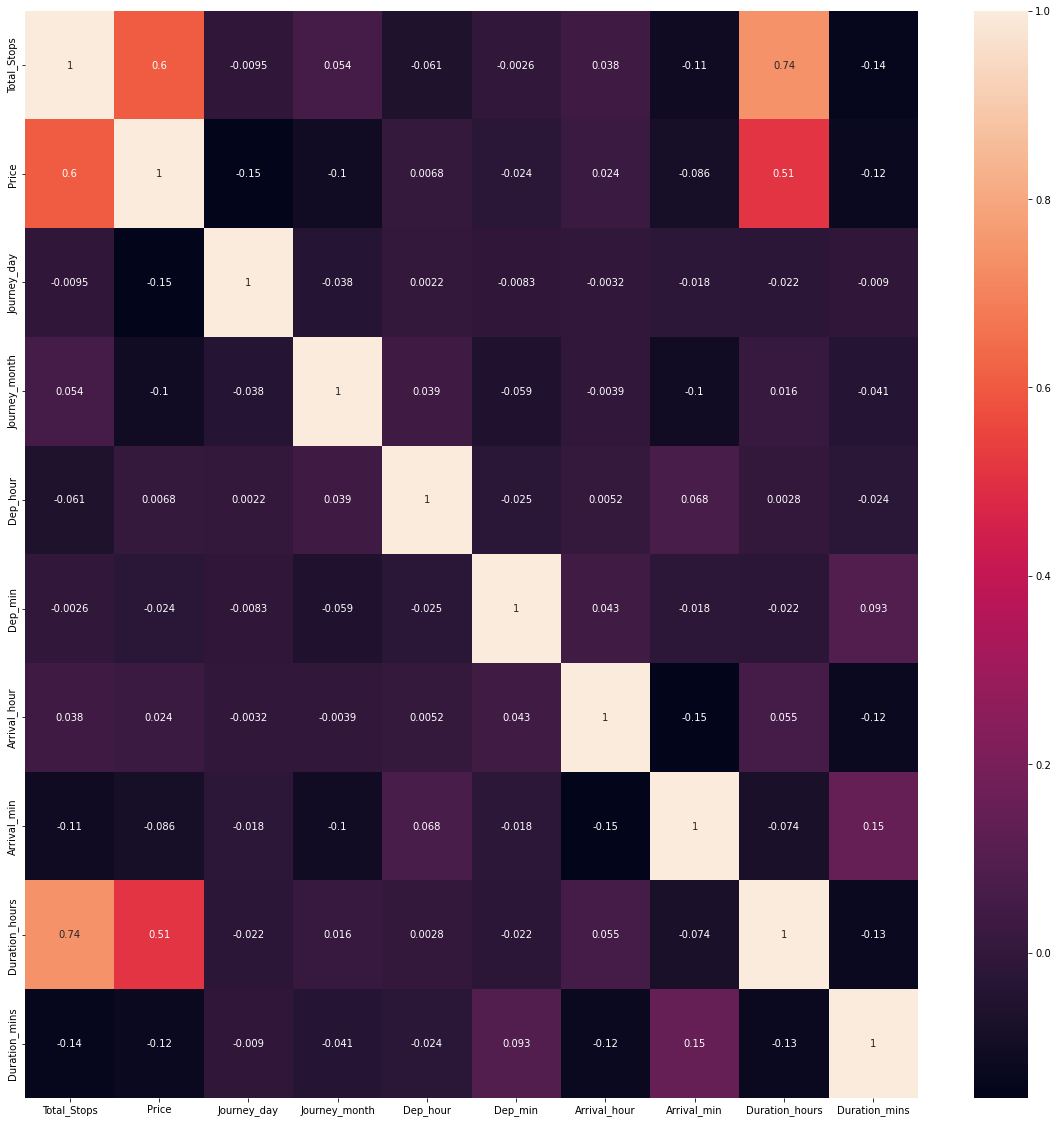

In [47]:
plt.figure(figsize = (20,20))
sns.heatmap(train_data.corr(), annot = True)

plt.show()

In [48]:
selection = ExtraTreesRegressor()
selection.fit(X, y)

ExtraTreesRegressor()

In [49]:
print(selection.feature_importances_)

[2.46876753e-01 1.44153439e-01 5.28293679e-02 2.46187851e-02
 2.10817406e-02 2.78769761e-02 1.91175510e-02 1.05765498e-01
 1.77678054e-02 9.36736260e-03 2.27641539e-03 1.92490971e-02
 1.34552591e-01 6.68292503e-02 1.74737556e-02 8.42582122e-04
 3.69305800e-03 4.99304705e-03 8.93020371e-05 4.55476522e-04
 9.57289296e-03 3.41597476e-03 7.25441791e-03 1.17027727e-02
 1.60748211e-02 6.76092978e-03 4.84046001e-04 2.48242914e-02]


A plot of feature importance in prediction of the flight price.

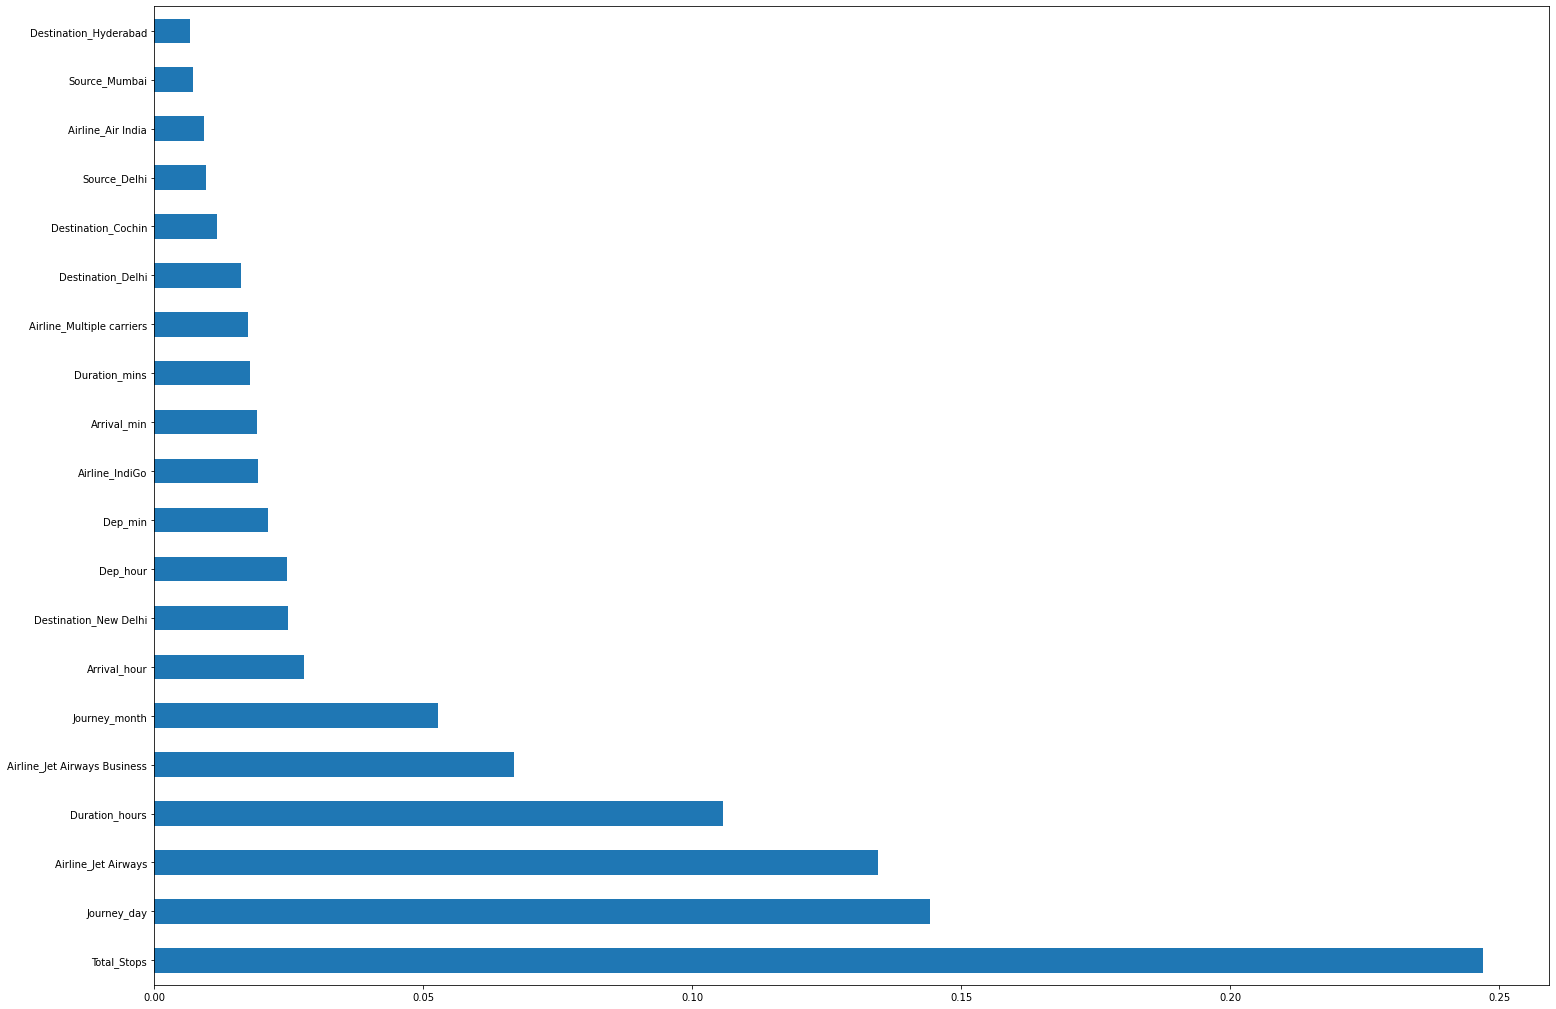

In [50]:
plt.figure(figsize = (25,18))
feat_importances = pd.Series(selection.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

# **Using Random Forests to fit an initial vague model**

**Test train split**

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)


**Scaling the data**

In [52]:
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

**Declaring the model and fitting the train data on it**

In [53]:
reg_rf = RandomForestRegressor()
reg_rf.fit(scaled_X_train, y_train)

RandomForestRegressor()

**Making Predictions**

In [54]:
y_pred = reg_rf.predict(scaled_X_test)

In [55]:
reg_rf.score(X_train, y_train)


0.25055861978764826

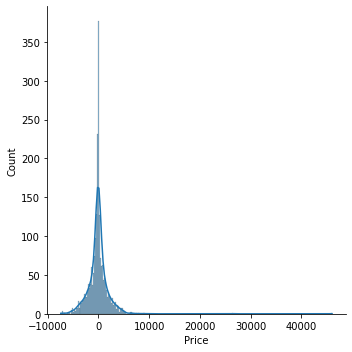

In [56]:
sns.displot(y_test-y_pred, kde = True)
plt.show()

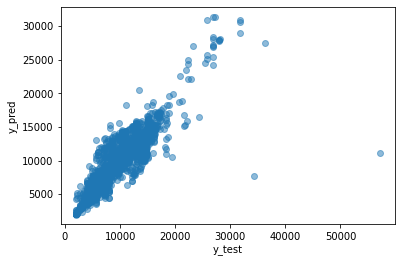

In [57]:

plt.scatter(y_test, y_pred, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

In [58]:
print('MAE:', mean_absolute_error(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))

MAE: 1183.3857448699846
MSE: 4402171.156029499
RMSE: 2098.1351615254675


In [59]:
r2_score(y_test, y_pred)

0.7958371367810333

**Clearly, This model is not performing that good, so we need to perform hyperparameter tuning on this**

**We will do this with the help of Randomized Search CV**

In [60]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]

In [61]:
# Creating the parameter grid

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [62]:
# Grid search of parameters, using 5 fold cross validation, search across 50 different combinations
final_model = RandomizedSearchCV(estimator = reg_rf, 
                               param_distributions = random_grid,
                               scoring='neg_mean_squared_error', 
                               n_iter = 10, cv = 5, verbose=2,
                               random_state=42, n_jobs = 1)

**Fitting the model on the Randomized Search CV instance.**

In [63]:
final_model.fit(scaled_X_train,y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   4.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   4.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   4.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   4.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   4.2s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1100; total time=   6.6s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1100; total time=   6.4s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimator

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [64]:
final_model.best_params_


{'n_estimators': 700,
 'min_samples_split': 15,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 20}

In [65]:
predictions = final_model.predict(scaled_X_test)

<Figure size 1440x1296 with 0 Axes>

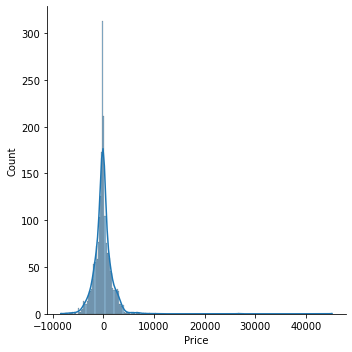

In [66]:
plt.figure(figsize = (20,18))
sns.displot(y_test-predictions, kde = True)
plt.show()

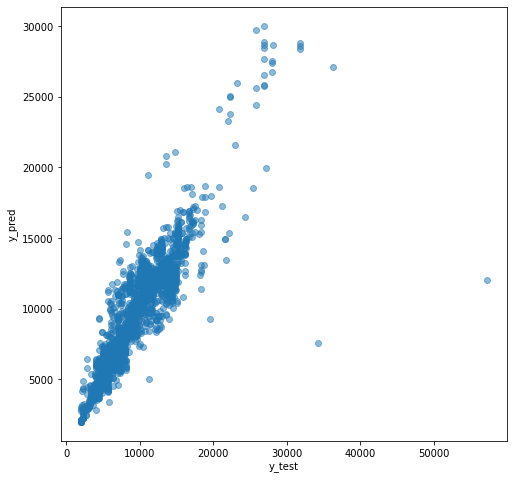

In [67]:
plt.figure(figsize = (8,8))
plt.scatter(y_test, predictions, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

**Clearly this is a much better model than the previous one!**

In [68]:
print('MAE:', mean_absolute_error(y_test, predictions))
print('MSE:', mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(mean_squared_error(y_test, predictions)))

MAE: 1165.515631089272
MSE: 4059891.7537278356
RMSE: 2014.9173069205187


In [69]:
r2_score(y_test, predictions)

0.8117112907650443

**r2_score has also improved to 81.2% value!**

**So I think we can use this model for our prediction puposes and hence our Flight Price Prediction model is completed**

# **TEST SET**

Now we need to import our test dataset and perform all the preprocessing steps again on it!
Basically this dataset is used for making predictions on a certain amount of data and it will be saved in the output

In [74]:
test_data = pd.read_csv('Test_set.csv')

In [75]:
test_data.drop('Unnamed: 0', axis = 1, inplace = True)

In [76]:
test_data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL → BOM → COK,17:30,04:25 07 Jun,10h 55m,1 stop,No info
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1 stop,No info
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL → BOM → COK,19:15,19:00 22 May,23h 45m,1 stop,In-flight meal not included
3,Multiple carriers,21/05/2019,Delhi,Cochin,DEL → BOM → COK,08:00,21:00,13h,1 stop,No info
4,Air Asia,24/06/2019,Banglore,Delhi,BLR → DEL,23:55,02:45 25 Jun,2h 50m,non-stop,No info


In [77]:
# Preprocessing

print("Test data Info")
print("-"*75)
print(test_data.info())

print('\n\n')

print("Null values :")
print("-"*75)
test_data.dropna(inplace = True)
print(test_data.isnull().sum())

# EDA

# Date_of_Journey
test_data["Journey_day"] = pd.to_datetime(test_data.Date_of_Journey, format="%d/%m/%Y").dt.day
test_data["Journey_month"] = pd.to_datetime(test_data["Date_of_Journey"], format = "%d/%m/%Y").dt.month
test_data.drop(["Date_of_Journey"], axis = 1, inplace = True)

# Dep_Time
test_data["Dep_hour"] = pd.to_datetime(test_data["Dep_Time"]).dt.hour
test_data["Dep_min"] = pd.to_datetime(test_data["Dep_Time"]).dt.minute
test_data.drop(["Dep_Time"], axis = 1, inplace = True)

# Arrival_Time
test_data["Arrival_hour"] = pd.to_datetime(test_data.Arrival_Time).dt.hour
test_data["Arrival_min"] = pd.to_datetime(test_data.Arrival_Time).dt.minute
test_data.drop(["Arrival_Time"], axis = 1, inplace = True)

# Duration
duration = list(test_data["Duration"])

for i in range(len(duration)):
    if len(duration[i].split()) != 2:    # Check if duration contains only hour or mins
        if "h" in duration[i]:
            duration[i] = duration[i].strip() + " 0m"   # Adds 0 minute
        else:
            duration[i] = "0h " + duration[i]           # Adds 0 hour

duration_hours = []
duration_mins = []
for i in range(len(duration)):
    duration_hours.append(int(duration[i].split(sep = "h")[0]))    # Extract hours from duration
    duration_mins.append(int(duration[i].split(sep = "m")[0].split()[-1]))   # Extracts only minutes from duration

# Adding Duration column to test set
test_data["Duration_hours"] = duration_hours
test_data["Duration_mins"] = duration_mins
test_data.drop(["Duration"], axis = 1, inplace = True)


# Categorical data

print("Airline")
print("-"*75)
print(test_data["Airline"].value_counts())
Airline = pd.get_dummies(test_data[["Airline"]], drop_first= True)

print()

print("Source")
print("-"*75)
print(test_data["Source"].value_counts())
Source = pd.get_dummies(test_data[["Source"]], drop_first= True)

print()

print("Destination")
print("-"*75)
print(test_data["Destination"].value_counts())
Destination = pd.get_dummies(test_data[["Destination"]], drop_first = True)

# Additional_Info contains almost 80% no_info
# Route and Total_Stops are related to each other
test_data.drop(["Route", "Additional_Info"], axis = 1, inplace = True)

# Replacing Total_Stops
test_data.replace({"non-stop": 0, "1 stop": 1, "2 stops": 2, "3 stops": 3, "4 stops": 4}, inplace = True)

# Concatenate dataframe --> test_data + Airline + Source + Destination
final_test_data = pd.concat([test_data, Airline, Source, Destination], axis = 1)

final_test_data.drop(["Airline", "Source", "Destination"], axis = 1, inplace = True)

print()
print()

print("Shape of test data : ", final_test_data.shape)

Test data Info
---------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2671 entries, 0 to 2670
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          2671 non-null   object
 1   Date_of_Journey  2671 non-null   object
 2   Source           2671 non-null   object
 3   Destination      2671 non-null   object
 4   Route            2671 non-null   object
 5   Dep_Time         2671 non-null   object
 6   Arrival_Time     2671 non-null   object
 7   Duration         2671 non-null   object
 8   Total_Stops      2671 non-null   object
 9   Additional_Info  2671 non-null   object
dtypes: object(10)
memory usage: 208.8+ KB
None



Null values :
---------------------------------------------------------------------------
Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time        

In [78]:
final_test_data.head()

,Total_Stops,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,1,6,6,17,30,4,25,10,55,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
1,1,12,5,6,20,10,20,4,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,1,21,5,19,15,19,0,23,45,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
3,1,21,5,8,0,21,0,13,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0
4,0,24,6,23,55,2,45,2,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [79]:
final_test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2671 entries, 0 to 2670
Data columns (total 28 columns):
 #   Column                                     Non-Null Count  Dtype
---  ------                                     --------------  -----
 0   Total_Stops                                2671 non-null   int64
 1   Journey_day                                2671 non-null   int64
 2   Journey_month                              2671 non-null   int64
 3   Dep_hour                                   2671 non-null   int64
 4   Dep_min                                    2671 non-null   int64
 5   Arrival_hour                               2671 non-null   int64
 6   Arrival_min                                2671 non-null   int64
 7   Duration_hours                             2671 non-null   int64
 8   Duration_mins                              2671 non-null   int64
 9   Airline_Air India                          2671 non-null   uint8
 10  Airline_GoAir                              2671 

**1. Scale this new data with already fitted scaler**

In [80]:
scaled_test_data = scaler.transform(final_test_data)

**2. Make predictions using already existing model**

In [81]:
price = final_model.predict(scaled_test_data)

In [82]:
price

array([11798.34605928,  4239.58644986, 14759.3589692 , ...,
       15782.19508579, 13869.92518288,  7823.29228518])

**3. Converting it to a pandas DataFrame**

In [83]:
price = pd.DataFrame(price, columns=['Predicted Price'])

In [84]:
price

,Predicted Price
0,11798.346059
1,4239.586450
2,14759.358969
3,11308.608198
4,3974.040094
...,...
2666,10271.281913
2667,4600.749398
2668,15782.195086
2669,13869.925183


**4. Saving this DataFrame as a csv file!**

In [85]:
price.to_csv('Predicted_Prices.csv')

# **THANK YOU!**

In [86]:
import pickle
# open a file, where you ant to store the data
file = open('flight_rf.pkl', 'wb')

# dump information to that file
pickle.dump(reg_rf, file)